# Data Wrangling, Analyzing and Visualizing of `WeRateDogs` Twitter Account Data

In [331]:
# Importing important modules
import pandas as pd 
import numpy as np 
import tweepy 
import requests 
import re
import matplotlib.pyplot as plt
import json
import os
from tweepy import OAuthHandler
from timeit import default_timer as timer
from sqlalchemy import create_engine

%matplotlib inline 

## Data Gathering (1st step of data wrangling)

### Gathering data from manually downloaded file (Source : File on hand, Format: CSV )

In [332]:
# Loading the data from the CSV file into pandas dataframe
archive_df = pd.read_csv("twitter-archive-enhanced.csv")

In [333]:
# Making sure that the data frame is right
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [334]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Gathering data from programmatically downloaded file (Source : From the internet, Format: TSV )

In [335]:
# Downloading the file from the given url
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
# Extracting the file name from the given URL
file_name = url.split('/')[-1]

In [336]:
# Checking if the extracting is right
file_name

'image-predictions.tsv'

In [337]:
# Getting the response object from the URL using the requests module
response = requests.get(url)

In [338]:
# Checking if the response if OK
response

<Response [200]>

In [339]:
# Writting the data from the file in the URL into a local file 
# WB is used as mode to decode the data right
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)

In [340]:
# Loading the data from the TSV file into pandas dataframe
image_predictions_df = pd.read_csv(file_name, sep='\t')

In [341]:
# Making sure the data frame is right
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Gathering data from Twitter API (Source : From API, Format: JSON.txt)


#### First Approach using the Twitter developer account

In [342]:
# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

# # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# # NOTE TO REVIEWER: this student had mobile verification issues so the following
# # Twitter API code was sent to this student from a Udacity instructor
# # Tweet IDs for which to gather additional data via Twitter's API
# tweet_ids = df_1.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

#### Second Approach using the pre-downloaded tweet_json.txt file

In [343]:
# Investigating the data first, to know which information we might need in analysis and visualization, so we can extract them
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        print(tweet.keys()) # to find out the data that we might need to use, and extract them next
        break

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])


In [344]:
# Reading the tweets info one by one into a list of dictionaries
df_list = []

with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
# Loading the data in the list into the dataframe        
api_df = pd.DataFrame(df_list)

In [345]:
# Making sure the dataframe is right
api_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


## Data Assessing (2nd step of data wrangling)

### Visual Assessment of the Data

<font color='red'> For the `archived_data`:

In [346]:
# Visual Assessment of the archieve enchanced data of the tweets
archive_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1557,688804835492233216,NaN,NaN,2016-01-17 19:27:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you stumble but recover quickly cause you...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688804835...,12,10,None,None,None,None,None
2147,669753178989142016,NaN,NaN,2015-11-26 05:42:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chester. He just ate a lot and now he can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669753178...,10,10,Chester,None,None,None,None
957,751538714308972544,NaN,NaN,2016-07-08 22:09:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Max. She has one ear that's always sli...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751538714...,10,10,Max,None,None,None,None
1150,726224900189511680,NaN,NaN,2016-04-30 01:41:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm getting super heckin frustrated with you a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/726224900...,9,10,None,None,None,None,None
147,863432100342583297,NaN,NaN,2017-05-13 16:33:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Belle. She's never been more pupset. E...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863432100...,12,10,Belle,None,None,None,None
630,794332329137291264,NaN,NaN,2016-11-04 00:15:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nimbus (like the cloud). He just bough...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/794332329...,12,10,Nimbus,None,None,None,None
346,831926988323639298,8.319030e+17,20683724.0,2017-02-15 18:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@UNC can confirm 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,https://twitter.com/dog_rates/status/756288534...,12,10,None,None,None,None,None
943,752701944171524096,NaN,NaN,2016-07-12 03:11:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: HEY PUP WHAT'S THE PART OF THE ...,6.835159e+17,4.196984e+09,2016-01-03 05:11:12 +0000,"https://vine.co/v/ibvnzrauFuV,https://vine.co/...",11,10,None,None,None,None,None
1770,678341075375947776,NaN,NaN,2015-12-19 22:28:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper likes tape. 12/10 https://t.co/cSp...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678341075...,12,10,None,None,None,pupper,None


<font color='red'>For the `image_predictions_data`:

In [347]:
# Visual Assessment of the data about predictions of the images
image_predictions_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1907,852553447878664193,https://pbs.twimg.com/media/C9Tg1bPW0AkAMDI.jpg,1,bloodhound,0.186498,True,Brabancon_griffon,0.139028,True,Rottweiler,0.125940,True
787,690374419777196032,https://pbs.twimg.com/media/CZSz3vWXEAACElU.jpg,1,kuvasz,0.286345,True,Labrador_retriever,0.107144,True,ice_bear,0.085086,False
1414,771014301343748096,https://pbs.twimg.com/media/CrMxZzgWIAQUxzx.jpg,1,meerkat,0.202335,False,doormat,0.111790,False,macaque,0.088925,False
24,666353288456101888,https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg,1,malamute,0.336874,True,Siberian_husky,0.147655,True,Eskimo_dog,0.093412,True
1025,710658690886586372,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True
999,708479650088034305,https://pbs.twimg.com/media/CdUGcLMWAAI42q0.jpg,1,Shih-Tzu,0.218479,True,Lhasa,0.201966,True,Norfolk_terrier,0.165225,True
99,667773195014021121,https://pbs.twimg.com/media/CURoLrOVEAAaWdR.jpg,1,West_Highland_white_terrier,0.360465,True,pug,0.093494,True,ice_bear,0.069038,False
1953,863907417377173506,https://pbs.twimg.com/media/C_03NPeUQAAgrMl.jpg,1,marmot,0.358828,False,meerkat,0.174703,False,weasel,0.123485,False
1550,793120401413079041,https://pbs.twimg.com/media/CwG6zDfWcAA8jBD.jpg,1,Labrador_retriever,0.724944,True,golden_retriever,0.169744,True,kuvasz,0.035502,True
599,679729593985699840,https://pbs.twimg.com/media/CW7iddWUsAElUC0.jpg,1,wallaby,0.164215,False,West_Highland_white_terrier,0.093515,True,ashcan,0.067278,False


<font color='red'>For the `api_data`:

In [348]:
# Visual Assessment of the interacting information (retweets and favourites) of the tweets
api_df.sample(10)

,favorite_count,retweet_count,tweet_id
1974,1001,328,672995267319328768
2096,887,403,670727704916926465
977,5569,2772,749981277374128128
1801,2354,980,676948236477857792
1347,1653,519,704134088924532736
565,0,5247,802247111496568832
904,3001,433,758041019896193024
2196,610,291,668815180734689280
1878,1057,252,675006312288268288
365,0,3901,828801551087042563


After investigating the data visually as above, I find that all data should be gathered into master data frame, so there would be more analysis and better visualization, which is a tidiness issue. Also, that the 4 columns of the stages of the dogs should be merged into only one column, which is also a tidiness issue. So, We need to dive deeper into investigating the data, to know more about the data typer, null values and other information, to decide more quality and tidiness issues.

### Programmatic Assessment of the data

<font color='red'> For the `archived_data`:

In [349]:
archive_df.info() # To check the data type of each variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [350]:
# Checking the values of rating_numerator for validity and accuarcy
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [351]:
#Check if the ids are unique
archive_df.tweet_id.is_unique

True

In [352]:
# Check for duplicates
sum(archive_df.duplicated())

0

In [353]:
# check name of dog
archive_df.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Tucker        10
Penny         10
Lola          10
Winston        9
Bo             9
the            8
Sadie          8
an             7
Bailey         7
Toby           7
Daisy          7
Buddy          7
Jax            6
Jack           6
Oscar          6
Dave           6
Rusty          6
Stanley        6
Milo           6
Leo            6
Koda           6
Scout          6
Bella          6
very           5
            ... 
Petrick        1
Suki           1
Aldrick        1
Mack           1
Odin           1
Bobb           1
Lulu           1
Pepper         1
Margo          1
Monkey         1
Arya           1
Siba           1
Carter         1
Nigel          1
Meatball       1
Dex            1
Benny          1
Ralph          1
Harnold        1
Bode           1
Spark          1
Goose          1
Randall        1
Dante          1
Jazz           1
Jarod          1
Jaspers        1
Bauer         

In [354]:
# check name of dog
archive_df.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Tucker        10
Penny         10
Lola          10
Winston        9
Bo             9
the            8
Sadie          8
an             7
Bailey         7
Toby           7
Daisy          7
Buddy          7
Jax            6
Jack           6
Oscar          6
Dave           6
Rusty          6
Stanley        6
Milo           6
Leo            6
Koda           6
Scout          6
Bella          6
very           5
            ... 
Petrick        1
Suki           1
Aldrick        1
Mack           1
Odin           1
Bobb           1
Lulu           1
Pepper         1
Margo          1
Monkey         1
Arya           1
Siba           1
Carter         1
Nigel          1
Meatball       1
Dex            1
Benny          1
Ralph          1
Harnold        1
Bode           1
Spark          1
Goose          1
Randall        1
Dante          1
Jazz           1
Jarod          1
Jaspers        1
Bauer         

In [355]:
# Cheking the values of the numerator of rating
archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [356]:
# Cheking the values of the denominator of rating
archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [357]:
# Checking the value of the numerator that is not equal 10
archive_df[archive_df.rating_denominator != 10]['rating_denominator'].value_counts().sum()

23

<font color='red'>For the `image_predictions_data`:

In [358]:
image_predictions_df.shape

(2075, 12)

In [359]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [360]:
# Checking for any duplicated images
sum(image_predictions_df.jpg_url.duplicated())

66

In [361]:
# Check the number many tweets have 1, 2, 3 or 4 images
image_predictions_df.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

<font color='red'>For the `api_data`:

In [362]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [363]:
sum(api_df.duplicated())

0

### Assessment Summary 
####  <font color='red'> Quality</font>

<font color='red'>For the `archieved_data`:</font>
- There are 78 replied tweets which is invalid data for our criteria, and 181 retweets which are also invalid data.
- The in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns should be removed as they are relate to the replies and retweets which are invalid for our data.
- tweet_id should be str not int, as we won't perform any numerical operations on it.
- The timestamp should be datetime type not string.
- Inaccurate extraction of the name of the dogs in some tweets (for example: a, not, an)
- The source column contains lots of infotmation that is needed to be cleand (HTML tags), also the source should be considered as category (finite sources).
- Inconsistent representation of the missing data (NaN and None str)
- Missing values in the name and dog stage (Insignificant information)

<font color='red'>For the `image_predictions_data`:</font>
- Some of the columns don't have descriptive names like p1, p1_conf, p1_dog ... etc
- 66 images were duplicated.
- tweet_id should be str not int, as we won't perform any numerical operationson it.
- The dog breeds have inconsistent representation (Some of them begin with lower letters while the other with capital ones, also some of them are separated with _ and the others with space).
    
<font color='red'>For the `api_data`:</font>
- tweet_id should be str not int, as we won't perform any numerical operationson it.
- The api has only 2354 while the archive has 2356, which means 2 missing IDs. (They can't be retrieved)

#### <font color='red'> Tidiness </font>
    
<font color='red'> For the `archived_data`:</font>
- The 4 columns that represent the stages of the dogs (doggo, floofer, pupper, puppo) should be considered as only 1 column as they represent values of one variable.
- A single observational unit is stored in multiple tables (archived_data, api_data, image_predictions_data) should all be gathered in 1 table.
    
<font color='red'>For the `image_predictions_data`:</font>
- The 3 columns that represent the breed prediction of the dogs should bs merged into only 1 column, and these existing columns should be values in the new column (variable).
- The 3 columns that represent the confidence of the predictions should bs merged into only 1 column, and these existing columns should be values in the new column (variable).
- A single observational unit is stored in multiple tables (archived_data, api_data, image_predictions_data) should all be gathered in 1 table.

<font color='red'>For the `api_data`:</font>
- A single observational unit is stored in multiple tables (archived_data, api_data, image_predictions_data) should all be gathered in 1 table.

## Data Cleaning

In [364]:
# Making copy of all the dataframes to apply the cleaning operations on these copies
clean_archive_df = archive_df.copy()
clean_image_predictions_df = image_predictions_df.copy()
clean_api_df = api_df.copy()

In [365]:
clean_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [366]:
clean_image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [367]:
clean_api_df

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256
5,20562,3261,891087950875897856
6,12041,2158,890971913173991426
7,56848,16716,890729181411237888
8,28226,4429,890609185150312448
9,32467,7711,890240255349198849


<font color= "red"> Now I will clean the above issues that I obeserved during the assessment phase, each issue will be cleaned in 3 steps **Define, Code, Test** </font>

### 1st Quality Issue

#### <font color= "red"> Define </font>

Remove the retweeted (non-original) tweets from the archived tweets dataset

#### <font color= "red">Code </font>

In [368]:
clean_archive_df = clean_archive_df[clean_archive_df.retweeted_status_id.isnull()]

#### <font color= "red">Test</font>

### 2nd Quality Issue

#### <font color= "red"> Define</font>

Remove the reply (non-original) tweets from the archived tweets dataset

#### <font color= "red">Code </font>

In [369]:
clean_archive_df = clean_archive_df[clean_archive_df.in_reply_to_user_id.isnull()]

#### <font color= "red">Test</test>

In [370]:
# The count values of non-null reply tweets related values (in_reply_to_user_id, in_reply_to_status_id) should be zero
clean_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### 3rd Quality Issue

#### <font color= "red"> Define</font>

Drop the columns of the retweet and the reply (non-original) information from the archived tweets dataset

#### <font color= "red">Code </font>

In [371]:
clean_archive_df.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id','retweeted_status_timestamp'], axis = 1, inplace = True)

#### <font color= "red">Test</test>

In [372]:
#The dropped columns shouldn't appear in the dataset
clean_archive_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 4th Quality Issue

#### <font color= "red"> Define</font>

Chnage the data type of the timestamp from object (str) to datetime

#### <font color= "red">Code </font>

In [373]:
clean_archive_df.timestamp = pd.to_datetime(clean_archive_df.timestamp)

#### <font color= "red">Test</test>

In [374]:
# The type of the timestamp should now be datetime
clean_archive_df.timestamp.dtypes

dtype('<M8[ns]')

### 5th Quality Issue

#### <font color= "red"> Define</font>

Change the data type of the tweet_id from int to str (in the 3 data sets)

#### <font color= "red">Code </font>

In [375]:
clean_archive_df.tweet_id = clean_archive_df.tweet_id.astype(str)
clean_image_predictions_df.tweet_id = clean_image_predictions_df.tweet_id.astype(str)
clean_api_df.tweet_id = clean_api_df.tweet_id.astype(str)

#### <font color= "red">Test</test>

In [376]:
print("Type of tweet_id in the archieved tweets dataset is", clean_archive_df.tweet_id.dtypes)
print("Type of tweet_id in the image predictions dataset is", clean_image_predictions_df.tweet_id.dtypes)
print("Type of tweet_id in the api dataset is", clean_api_df.tweet_id.dtypes)

Type of tweet_id in the archieved tweets dataset is object
Type of tweet_id in the image predictions dataset is object
Type of tweet_id in the api dataset is object


### 6th Quality Issue

#### <font color= "red"> Define</font>

Replace the wrong extracted names in the archived dataset to None

#### <font color= "red">Code </font>

In [377]:
# First check for the names that got extracted wrong (from the investigation of the data visually and programatically, we find that 
# the names got extracted wrong were normal words in the texts (with all lower letters))
wrong_names = clean_archive_df[clean_archive_df.name.str.islower()].name.unique()
wrong_names

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my',
       'his', 'an', 'actually', 'just', 'getting', 'mad', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [378]:
# Check the None values count to use it in the test comparison
clean_archive_df.name.value_counts()

None           603
a               55
Charlie         11
Lucy            11
Cooper          10
Oliver          10
Tucker           9
Penny            9
the              8
Sadie            8
Winston          8
Lola             8
Daisy            7
Toby             7
Koda             6
Bailey           6
Jax              6
an               6
Bella            6
Bo               6
Stanley          6
Oscar            6
Leo              5
Dave             5
Scout            5
Rusty            5
Chester          5
Bentley          5
Buddy            5
Milo             5
              ... 
Arlen            1
Kloey            1
Klein            1
Shakespeare      1
Ralph            1
Benny            1
Dex              1
Kenny            1
Seamus           1
Smiley           1
Levi             1
Alexander        1
Bobby            1
Grey             1
Glacier          1
Kathmandu        1
Tebow            1
Rorie            1
Anthony          1
Richie           1
Chef             1
Howie       

In [379]:
# Now, we know the wrong names, and we should replace them with none
for name in wrong_names:
    clean_archive_df.name.replace(name, 'None',inplace=True)

#### <font color= "red">Test</test>

In [380]:
# We can test that by comparing the count of None values in before replacing the wrong names (which was 603) and the clean one
# The None count should be bigger in the clean one (after replacement of wrong extracted names)
clean_archive_df.name.value_counts()

None           707
Charlie         11
Lucy            11
Oliver          10
Cooper          10
Tucker           9
Penny            9
Winston          8
Sadie            8
Lola             8
Toby             7
Daisy            7
Bailey           6
Stanley          6
Bella            6
Bo               6
Koda             6
Jax              6
Oscar            6
Milo             5
Leo              5
Louis            5
Buddy            5
Rusty            5
Dave             5
Scout            5
Chester          5
Bentley          5
Derek            4
Chip             4
              ... 
Barclay          1
Arlen            1
Kloey            1
Klein            1
Shakespeare      1
Margo            1
Ralph            1
Benny            1
Anthony          1
Smiley           1
Levi             1
Alexander        1
Bobby            1
Grey             1
Glacier          1
Kathmandu        1
Tebow            1
Rorie            1
Richie           1
Dex              1
Chef             1
Howie       

### 7th Quality Issue

#### <font color= "red"> Define</font>

Extracting the source of twitter used in the archived_tweets dataset, by extracting only the text between the HTML anchors

#### <font color= "red">Code </font>

In [381]:
# Removing anydata from the source column except the used source itself 
clean_archive_df.source = clean_archive_df.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')
# Making the source considered ad categorial datatype
clean_archive_df.source = clean_archive_df.source.astype('category')

#### <font color= "red">Test</test>

In [382]:
#Testing by checking that there's not any column that contains null value in any cleaned df
clean_archive_df.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1910,674416750885273600,2015-12-09 02:34:18,Twitter for iPhone,This is Jonah. He's a Stinted Fisher Price. En...,https://twitter.com/dog_rates/status/674416750...,10,10,Jonah,None,None,None,None
1661,683030066213818368,2016-01-01 21:00:32,Twitter for iPhone,This is Lulu. She's contemplating all her unre...,https://twitter.com/dog_rates/status/683030066...,10,10,Lulu,None,None,None,None
1789,677547928504967168,2015-12-17 17:56:29,Twitter for iPhone,Not much to say here. I just think everyone ne...,https://twitter.com/dog_rates/status/677547928...,12,10,None,None,None,None,None
1340,704859558691414016,2016-03-02 02:43:09,Twitter for iPhone,Here is a heartbreaking scene of an incredible...,https://twitter.com/dog_rates/status/704859558...,10,10,None,None,None,pupper,None
1644,683852578183077888,2016-01-04 03:28:54,Twitter for iPhone,Say hello to Tiger. He's a penbroke (little do...,https://twitter.com/dog_rates/status/683852578...,10,10,Tiger,None,None,None,None
969,750132105863102464,2016-07-05 01:00:05,Twitter for iPhone,This is Stewie. He will roundhouse kick anyone...,https://twitter.com/dog_rates/status/750132105...,11,10,Stewie,None,None,None,None
1584,687096057537363968,2016-01-13 02:17:20,Twitter for iPhone,This pupper's New Year's resolution was to bec...,https://twitter.com/dog_rates/status/687096057...,11,10,None,None,None,pupper,None
1900,674664755118911488,2015-12-09 18:59:46,Twitter for iPhone,This is Rodman. He's getting destroyed by the ...,https://twitter.com/dog_rates/status/674664755...,10,10,Rodman,None,None,None,None
1478,693590843962331137,2016-01-31 00:25:18,Twitter for iPhone,Meet Phil. He's big af. Currently destroying t...,https://twitter.com/dog_rates/status/693590843...,3,10,Phil,None,None,pupper,None


### 8th Quality Issue

#### <font color= "red"> Define</font>

Change the column names to more descriptive ones in the image_predections dataset

#### <font color= "red">Code </font>

In [383]:
clean_image_predictions_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [384]:
clean_image_predictions_df = clean_image_predictions_df.rename(columns={"jpg_url": "image_url",
                                           "img_num": "image_number",
                                           "p1": "first_prediction",
                                           "p1_conf" : "first_prediction_confidence",
                                           "p1_dog" : "first_prediction_dog",
                                           "p2": "second_prediction",
                                           "p2_conf" : "second_prediction_confidence",
                                           "p2_dog" : "second_prediction_dog",
                                           "p3": "third_prediction",
                                           "p3_conf" : "third_prediction_confidence",
                                           "p3_dog" : "third_prediction_dog"})

#### <font color= "red">Test</test>

In [385]:
# The count values of non-null reply tweets related values (in_reply_to_user_id, in_reply_to_status_id) should be zero
clean_image_predictions_df.columns

Index(['tweet_id', 'image_url', 'image_number', 'first_prediction',
       'first_prediction_confidence', 'first_prediction_dog',
       'second_prediction', 'second_prediction_confidence',
       'second_prediction_dog', 'third_prediction',
       'third_prediction_confidence', 'third_prediction_dog'],
      dtype='object')

### 9th Quality Issue

#### <font color= "red"> Define</font>

Make all the breeds in the image_predictions dataset lowercase and separated with *_*

#### <font color= "red">Code </font>

In [386]:
# The 3 columns that include breeds
breeds = ['first_prediction', 'second_prediction', 'third_prediction']

# Replace space with _ and make all the word lowercase
for breed in breeds:
    clean_image_predictions_df[breed] = clean_image_predictions_df[breed].str.replace(' ', '_')
    clean_image_predictions_df[breed] = clean_image_predictions_df[breed].str.lower()

#### <font color= "red">Test</test>

In [387]:
# Checking a sample of the data to show the change
clean_image_predictions_df.sample(10)

,tweet_id,image_url,image_number,first_prediction,first_prediction_confidence,first_prediction_dog,second_prediction,second_prediction_confidence,second_prediction_dog,third_prediction,third_prediction_confidence,third_prediction_dog
1125,727314416056803329,https://pbs.twimg.com/media/Chfwmd9U4AQTf1b.jpg,2,toy_poodle,0.827469,True,miniature_poodle,0.160760,True,tibetan_terrier,0.001731,True
2016,879862464715927552,https://pbs.twimg.com/media/DDXmPrbWAAEKMvy.jpg,3,basset,0.813507,True,beagle,0.146654,True,cocker_spaniel,0.009485,True
317,671744970634719232,https://pbs.twimg.com/media/CVKEfMKWoAAR-Ud.jpg,1,ice_bear,0.251193,False,ram,0.213839,False,arctic_fox,0.081551,False
138,668537837512433665,https://pbs.twimg.com/media/CUcfnWlWsAAzlwE.jpg,1,lakeland_terrier,0.372988,True,toy_poodle,0.250445,True,chihuahua,0.189737,True
1513,786595970293370880,https://pbs.twimg.com/media/CuqM0fVWAAAboKR.jpg,1,pembroke,0.709512,True,cardigan,0.287178,True,chow,0.000570,True
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,pembroke,0.809197,True,rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
1451,776477788987613185,https://pbs.twimg.com/media/CsaaaaxWgAEfzM7.jpg,1,labrador_retriever,0.884839,True,chesapeake_bay_retriever,0.057565,True,paintbrush,0.005766,False
699,684594889858887680,https://pbs.twimg.com/media/CYAra7JWsAACPZH.jpg,1,weimaraner,0.948688,True,english_setter,0.035352,True,brittany_spaniel,0.003879,True
279,671109016219725825,https://pbs.twimg.com/media/CVBCFkyU4AE2Wcr.jpg,1,basenji,0.855959,True,beagle,0.036723,True,toy_terrier,0.029258,True
958,705475953783398401,https://pbs.twimg.com/media/CcpaoR9WAAAKlJJ.jpg,1,golden_retriever,0.908784,True,labrador_retriever,0.030361,True,tennis_ball,0.004996,False


### 10th Quality Issue

#### <font color= "red"> Define</font>

Drop the 66 duplicated images' URL in the image_predictions dataset

#### <font color= "red">Code </font>

In [388]:
clean_image_predictions_df = clean_image_predictions_df.drop_duplicates(subset=['image_url'], keep='last')

#### <font color= "red">Test</test>

In [389]:
sum(clean_image_predictions_df.image_url.duplicated())

0

### 11th Quality Issue

#### <font color= "red"> Define</font>

Replace the Nan values with None str for consistency in all the data frames

#### <font color= "red">Code </font>

In [390]:
clean_image_predictions_df = clean_image_predictions_df.replace(np.nan, "None")
clean_archive_df = clean_archive_df.replace(np.nan, "None")
clean_api_df = clean_api_df.replace(np.nan, "None")

#### <font color= "red">Test</test>

In [391]:
#Testing by checking that there's not any column that contains null value in any cleaned df
clean_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null object
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [392]:
clean_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 213.0+ KB


In [393]:
clean_image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                        2009 non-null object
image_url                       2009 non-null object
image_number                    2009 non-null int64
first_prediction                2009 non-null object
first_prediction_confidence     2009 non-null float64
first_prediction_dog            2009 non-null bool
second_prediction               2009 non-null object
second_prediction_confidence    2009 non-null float64
second_prediction_dog           2009 non-null bool
third_prediction                2009 non-null object
third_prediction_confidence     2009 non-null float64
third_prediction_dog            2009 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 162.8+ KB


### 1st Tidiness Issue

#### <font color= "red"> Define</font>

Create a dog_stage column and make the 4 columns ("doggo", "floofer", "pupper" and "puppo") values within it, to achive the tidiness rule the *Each variable forms a column and contains values*

#### <font color= "red">Code </font>

In [394]:
# Extract the dog stage from the original text, and add it as a value of the new column dog_stage
for index, column in clean_archive_df.iterrows():
    for stage in ['puppo', 'pupper', 'doggo', 'floofer']:
        if stage.lower() in str(clean_archive_df.loc[index, 'text']).lower():
            clean_archive_df.loc[index, 'dog_stage'] = stage
clean_archive_df = clean_archive_df.replace(np.nan, 'None' ) # For data consistecny (Previously solved problem)

In [395]:
# Drop the 4 columns of the stages ('puppo', 'pupper', 'doggo', 'floofer')
clean_archive_df.drop(['puppo','pupper', 'doggo','floofer'],axis=1, inplace=True)

#### <font color= "red">Test</test>

In [396]:
# The count values of non-null reply tweets related values (in_reply_to_user_id, in_reply_to_status_id) should be zero
clean_archive_df.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
417,822489057087389700,2017-01-20 17:00:46,Twitter for iPhone,This is Paisley. She really wanted to be presi...,https://twitter.com/dog_rates/status/822489057...,13,10,Paisley,None
2346,666058600524156928,2015-11-16 01:01:59,Twitter for iPhone,Here is the Rand Paul of retrievers folks! He'...,https://twitter.com/dog_rates/status/666058600...,8,10,None,None
1408,699072405256409088,2016-02-15 03:27:04,Twitter for iPhone,ERMAHGERD 12/10 please enjoy https://t.co/7WrA...,https://twitter.com/dog_rates/status/699072405...,12,10,None,None
1702,680934982542561280,2015-12-27 02:15:25,Twitter for iPhone,Say hello to Sadie. She's a Tortellini Sidewin...,https://twitter.com/dog_rates/status/680934982...,10,10,Sadie,None
757,778624900596654080,2016-09-21 16:00:17,Twitter for iPhone,This is Penny. She's a sailor pup. 11/10 would...,https://twitter.com/dog_rates/status/778624900...,11,10,Penny,None
1328,705970349788291072,2016-03-05 04:17:02,Twitter for iPhone,This is Lucy. She's a Venetian Kerploof. Suppo...,https://twitter.com/dog_rates/status/705970349...,12,10,Lucy,None
1182,718971898235854848,2016-04-10 01:20:33,Twitter for iPhone,This is Sadie. She is prepared for battle. 10/...,https://twitter.com/dog_rates/status/718971898...,10,10,Sadie,None
2205,668633411083464705,2015-11-23 03:33:22,Twitter for iPhone,This is Churlie. He likes bagels. 10/10 https:...,https://twitter.com/dog_rates/status/668633411...,10,10,Churlie,None
754,778764940568104960,2016-09-22 01:16:45,Twitter for iPhone,Oh my god it's Narcos but Barkos. 13/10 someon...,https://m.youtube.com/watch?v=idKxCMsS3FQ&feat...,13,10,None,None
2137,670046952931721218,2015-11-27 01:10:17,Twitter for iPhone,This is Ben &amp; Carson. It's impossible for ...,https://twitter.com/dog_rates/status/670046952...,11,10,Ben,None


### 2nd Tidiness Issue

#### <font color= "red"> Define</font>

Create a breed_prediction column that holds the values of breeds in the 3 columns (first_prediction, second_prediction, and third_prediction)values within it, according to which prediction holds a True first in the 3 columns (first_prediction_dog, second_prediction_dog, third_prediction_dog)respectivley. Also, Create a prediction_confidence column that holds the values in the 3 columns (first_prediction_confidence, second_prediction_confidence, and third_prediction_confidence)values within it, according to which prediction was already chosen as the breed_prediction. These two columns are constructed 
to achive the tidiness rule the *Each variable forms a column and contains values*

#### <font color= "red">Code </font>

In [397]:
#Create two lists to store the value of the first breed prediction and its crossponding confidence value
breed_prediction_list = []
prediction_confidence_list = []

# Create a function that determines which prediction holds a TRUE value first, so it sill be the breed_prediction, along with its confidence
def predict_breeds(clean_image_predictions_df):
    if clean_image_predictions_df['first_prediction_dog'] == True:
        breed_prediction_list.append(clean_image_predictions_df['first_prediction'])
        prediction_confidence_list.append(clean_image_predictions_df['first_prediction_confidence'])
    elif clean_image_predictions_df['second_prediction_dog'] == True:
        breed_prediction_list.append(clean_image_predictions_df['second_prediction'])
        prediction_confidence_list.append(clean_image_predictions_df['second_prediction_confidence'])
    elif clean_image_predictions_df['third_prediction_dog'] == True:
        breed_prediction_list.append(clean_image_predictions_df['third_prediction'])
        prediction_confidence_list.append(clean_image_predictions_df['third_prediction_confidence'])
    else:
        breed_prediction_list.append('None')
        prediction_confidence_list.append('None')

# Apply the function on the columns of the image_predictions dataset
clean_image_predictions_df.apply(predict_breeds, axis=1)


clean_image_predictions_df['breed_prediction'] = breed_prediction_list
clean_image_predictions_df['prediction_confidence'] = prediction_confidence_list


In [398]:
# Drop any tweets with non-recoginzed breed as it won't be valid for our analysis 
clean_image_predictions_df = clean_image_predictions_df[clean_image_predictions_df.breed_prediction != 'None']

# Drop the columns that aren't needed any more
clean_image_predictions_df.drop(['first_prediction','first_prediction_confidence', 'first_prediction_dog'
                       ,'second_prediction' , 'second_prediction_confidence', 'second_prediction_dog'
                       ,'third_prediction', "third_prediction_confidence", 'third_prediction_dog' ],axis=1, inplace=True)

#### <font color= "red">Test</test>

In [399]:
# The count values of non-null reply tweets related values (in_reply_to_user_id, in_reply_to_status_id) should be zero
clean_image_predictions_df.sample(10)

,tweet_id,image_url,image_number,breed_prediction,prediction_confidence
1359,760893934457552897,https://pbs.twimg.com/media/Co88_ujWEAErCg7.jpg,1,blenheim_spaniel,0.113992
1086,718631497683582976,https://pbs.twimg.com/media/CfkXiX6W4AAmICF.jpg,1,pomeranian,0.993718
962,705970349788291072,https://pbs.twimg.com/media/CcwcSS9WwAALE4f.jpg,1,golden_retriever,0.776346
1181,738184450748633089,https://pbs.twimg.com/media/Cj6O1G9UYAAIU-1.jpg,1,bedlington_terrier,0.289471
681,683828599284170753,https://pbs.twimg.com/media/CX1ye7HUMAADDzh.jpg,1,malamute,0.577376
452,674752233200820224,https://pbs.twimg.com/media/CV0zkzEU4AAzLc5.jpg,2,vizsla,0.665516
1681,813812741911748608,https://pbs.twimg.com/media/C0s-XtzWgAAp1W-.jpg,1,french_bulldog,0.709146
102,667801013445750784,https://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg,1,flat-coated_retriever,0.508392
475,675149409102012420,https://pbs.twimg.com/media/CV6czeEWEAEdChp.jpg,1,chow,0.999876
1131,728046963732717569,https://pbs.twimg.com/media/ChqK2cVWMAAE5Zj.jpg,1,newfoundland,0.255971


### 3rd Tidiness Issue

#### <font color= "red"> Define</font>

Merging the 3 clean datasets into a master one to achive the data tidiness rule that *Each type of observational unit forms a table* where the original tweet with dog image is the observational unit here. We will merge the tweets with the matchind IDs in the 3 datasets to make sure that any invalid data is excluded.

#### <font color= "red">Code </font>

In [400]:
# merge twitter_archive_clean with predictions_clean
twitter_master_df = pd.merge(clean_archive_df, clean_image_predictions_df, how = 'inner', on = ['tweet_id']).copy()

# merge complete_df with twitter_add_info_clean
twitter_master_df = pd.merge(twitter_master_df, clean_api_df, how = 'inner', on = ['tweet_id']).copy()

#### <font color= "red">Test</test>

In [401]:
twitter_master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,image_url,image_number,breed_prediction,prediction_confidence,favorite_count,retweet_count
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,33819,6514
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,25461,4328
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,labrador_retriever,0.168086,42908,8964
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,41048,9774
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,chesapeake_bay_retriever,0.425595,20562,3261


In [402]:
twitter_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 15 columns):
tweet_id                 1606 non-null object
timestamp                1606 non-null datetime64[ns]
source                   1606 non-null object
text                     1606 non-null object
expanded_urls            1606 non-null object
rating_numerator         1606 non-null int64
rating_denominator       1606 non-null int64
name                     1606 non-null object
dog_stage                1606 non-null object
image_url                1606 non-null object
image_number             1606 non-null int64
breed_prediction         1606 non-null object
prediction_confidence    1606 non-null object
favorite_count           1606 non-null int64
retweet_count            1606 non-null int64
dtypes: datetime64[ns](1), int64(5), object(9)
memory usage: 200.8+ KB


## Data Storing

### Storing wrangled data into a CSV file

In [403]:
twitter_master_df.to_csv('twitter_archive_master.csv' ,index = False)

## Data Analysis and Visualization

### What is the most frequently reported dog stage?

In [404]:
twitter_master_df.dog_stage.value_counts()

None       1331
pupper      181
doggo        61
puppo        25
floofer       8
Name: dog_stage, dtype: int64

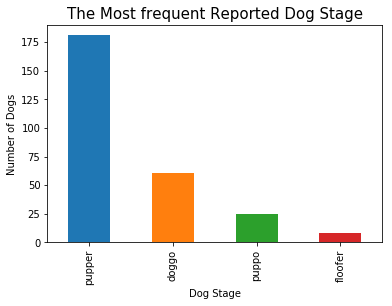

In [405]:
twitter_master_df.dog_stage.value_counts()[1:5].sort_values(ascending=False).plot(kind = 'bar') # The slicing is done to exclude the None value
plt.ylabel('Number of Dogs')
plt.title('The Most frequent Reported Dog Stage', size=15)
plt.xlabel('Dog Stage');

<font color= 'green'> We find that *Pupper* is the most common dog stage in the published posts. </font>

### What are the most popular dog breeds?

In [406]:
twitter_master_df.breed_prediction.value_counts()

golden_retriever                  141
labrador_retriever                101
pembroke                           93
chihuahua                          86
pug                                60
toy_poodle                         49
chow                               45
pomeranian                         41
samoyed                            38
malamute                           32
chesapeake_bay_retriever           31
french_bulldog                     30
cocker_spaniel                     26
miniature_pinscher                 23
eskimo_dog                         22
german_shepherd                    21
siberian_husky                     20
shih-tzu                           20
cardigan                           19
beagle                             19
staffordshire_bullterrier          19
maltese_dog                        19
shetland_sheepdog                  18
rottweiler                         18
kuvasz                             17
basset                             17
italian_grey

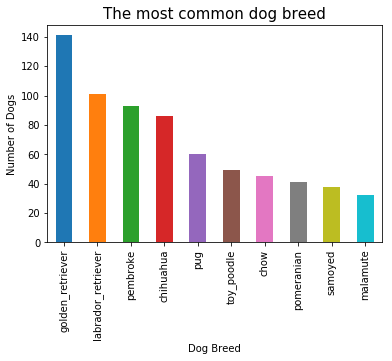

In [407]:
twitter_master_df.breed_prediction.value_counts()[:10].sort_values(ascending=False).plot(kind = 'bar') # The slicing is done to exclude the None value
plt.ylabel('Number of Dogs')
plt.title('The most common dog breed', size=15)
plt.xlabel('Dog Breed');


<font color= 'green'> We find that *Golden Retriever* is the most common dog breed in the published posts. </font>

### What are the most common source used for the tweets?

In [408]:
twitter_master_df.source.value_counts()

Twitter for iPhone    1577
Twitter Web Client      20
TweetDeck                9
Name: source, dtype: int64

<font color= 'green'> We find that *Twitter for iphone* is the most common source. </font>

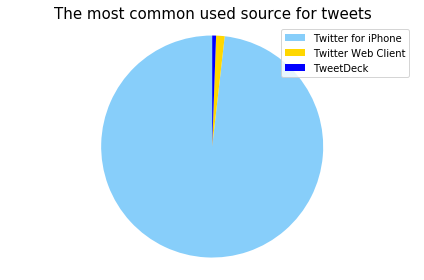

In [409]:
labels = twitter_master_df.source.unique().tolist() 
sizes = []
for label in labels:
    size =twitter_master_df[twitter_master_df.source == label].shape[0]
    sizes.append(size)

colors = ['lightskyblue', 'gold', 'blue']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.title('The most common used source for tweets', size=15)
plt.tight_layout()
plt.show()

### How is the activity of WeRateDogs account over time?

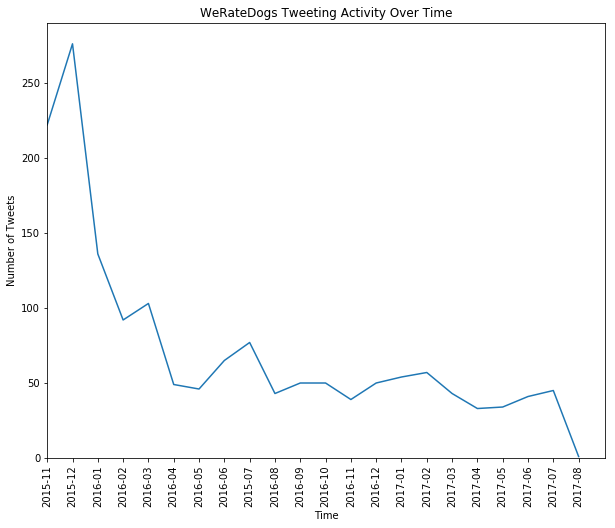

In [410]:
data = twitter_master_df.tweet_id.groupby([twitter_master_df["timestamp"].dt.year, twitter_master_df["timestamp"].dt.month]).count()
tweets_number = data.plot(kind='line', title='WeRateDogs Tweeting Activity Over Time', figsize = (10,8))
tweets_number.set_xlabel("Time")
tweets_number.set_ylabel("Number of Tweets")
tweets_number.set_ylim(0, )
tweets_number.set_xlim(0, )
tweets_number.set_xticks(np.arange(0,22))
tweets_number.set_xticklabels(['2015-11','2015-12','2016-01','2016-02','2016-03','2016-04',
                               '2016-05','2016-06','2015-07','2016-08','2016-09','2016-10', 
                              '2016-11','2016-12','2017-01','2017-02','2017-03','2017-04',
                               '2017-05','2017-06','2017-07','2017-08'], rotation = 90);


<font color= 'green'> It seems that the activity of the accounts which can be measured with the number of posts dcreased with time, and also, it had its peak by the end of 2015. </font>

### How is the interactions (retweets and favourites) with the posts  over time?

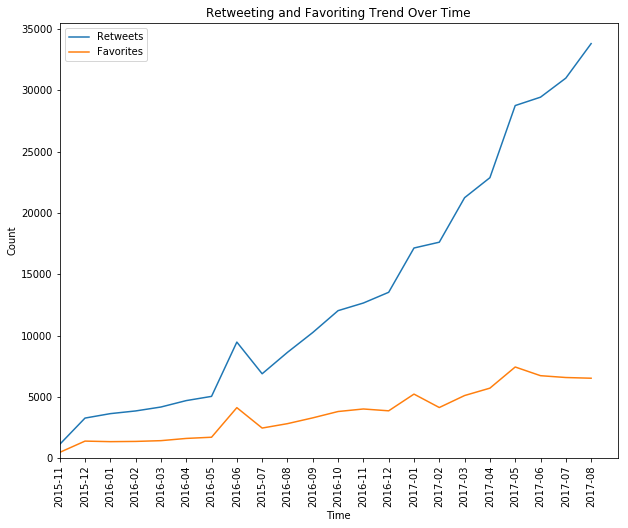

In [411]:
retweet_data = twitter_master_df.retweet_count.groupby([twitter_master_df["timestamp"].dt.year, twitter_master_df["timestamp"].dt.month]).mean()
favourite_data = twitter_master_df.favorite_count.groupby([twitter_master_df["timestamp"].dt.year, twitter_master_df["timestamp"].dt.month]).mean()
plt.figure(figsize=(10, 8))
favourite_plot = favourite_data.plot(kind='line')
retweet_plot = retweet_data.plot(kind='line')
favourite_plot.set_xlim(0, )
retweet_plot.set_ylim(0, )
plt.title('Retweeting and Favoriting Trend Over Time')
plt.ylabel('Count')
plt.xlabel('Time')
plt.xticks(np.arange(0,22),['2015-11','2015-12','2016-01','2016-02','2016-03','2016-04',
                               '2016-05','2016-06','2015-07','2016-08','2016-09','2016-10', 
                              '2016-11','2016-12','2017-01','2017-02','2017-03','2017-04',
                               '2017-05','2017-06','2017-07','2017-08'], rotation = 90);
plt.legend(('Retweets', 'Favorites'));

<font color= 'green'> From this visualization, we find that the trend of interactions with the posts via retweets and favourits has increased over time, which is logical due to the increase of followers and media coverage over time. </font>